# Parse data from .txt or .csv files

In [2]:
import csv


def parse_txt(filename, oriented=True):
    """
    Parse data from txt file into dict python type.
    JSON serializable.
    """
    data = {}
    with open(filename) as file:

        line = file.readline()
        while line:

            # skip comments
            if line[0] == '#':
                line = file.readline()
                continue

            parent, child = line.split()
            parent = int(parent)
            child = int(child)

            # rows in data file can be duplicated
            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = {
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }

            if oriented:
                if child not in data:
                    data[child] = {
                        'linked': [],
                        'distances': {},
                        'degree': 0,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            line = file.readline()

    return data


def parse_csv(filename, oriented=True):
    data = {}

    with open(filename) as file:
        reader = csv.reader(file)
        next(reader)

        for row in reader:

            parent = int(row[0])
            child = int(row[1])

            if parent in data:
                if child not in data[parent]['linked']:
                    data[parent]['linked'].append(child)
                    data[parent]['degree'] += 1
            else:
                data[parent] = {
                    'linked': [child],
                    'distances': {},
                    'degree': 1,
                    'centrality': 0,
                    'marked': False,
                    'active': True
                }

            if oriented:
                if child not in data:
                    data[child] = {
                        'linked': [],
                        'distances': {},
                        'degree': 0,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

            else:
                if child in data:
                    if parent not in data[child]['linked']:
                        data[child]['linked'].append(parent)
                        data[child]['degree'] += 1

                else:
                    data[child] = {
                        'linked': [parent],
                        'distances': {},
                        'degree': 1,
                        'centrality': 0,
                        'marked': False,
                        'active': True
                    }

    return data


def parse(filename, oriented=True):
    if filename.split('.')[-1] == 'txt':
        return parse_txt(filename, oriented)
    elif filename.split('.')[-1] == 'csv':
        return parse_csv(filename, oriented)

# Distance counting method with modifications

In [5]:
from collections import deque 
import datetime as dt

def count_distance(vertice, data, h = -1, full=False, rollback=True, monitoring=False):
    """
    Counts distances form given vertice to all other in connectivity component that vertice belongs to.
    Also, of h parameter is provided, this method finds list of vertices which are h or less away from provided vertice.
    (As only distance from provided vertive becomes more then h method stops.)
    Based on BFS.
    vertice: index of source vertice
    data: dict with information about graph
    h: distance to closest vertices
    fill: complete BFS in spite of current distance > h
    """

    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    current_distance = 0
    centrality = 0
    vertices_number = 1
    nearest_vertices = []
    d0 = deque()
    d1 = deque()
    
    source_active = data[vertice]['active']
    
    d0.append(vertice)
    data[vertice]['marked'] = True
    
    operations_counter += 9
    
    while True:
        
        if (not d0 and not d1) or (h != -1 and current_distance > h and not full):
            operations_counter += 9
            break
        
        if current_distance % 2 == 0:
            
            v = d0.popleft()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 2
                
            # go to the next level of distance from the source vertice 'vertice'
            if not d0:
                current_distance += 1
                                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s
                
        else:
            
            v = d1.popleft()
                
            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True
                    
                    operations_counter += 2
                operations_counter += 2
            
            data[v]['distances'][vertice] = current_distance
            vertices_number += 1
            centrality += current_distance
            
            # set active to false if it vertice 'v' is too close to source vertice 'vertice'
            if h != -1 and current_distance <= h:
                data[v]['active'] = False
                nearest_vertices.append(v)
                
                operations_counter += 3
            
            # go to the next level of distance from the source vertice 'vertice'
            if not d1:
                current_distance += 1
                
                operations_counter += 1
                
            operations_counter += 5 # number of "if"'s added
    
    # rollback data
    if rollback:
        for key, value in data.items():
            value['marked'] = False
    
    # set initial status
    data[vertice]['active'] = source_active
    
    operations_counter =+ 1
    
    if full:
        data[vertice]['centrality'] = centrality / vertices_number
        operations_counter += 4
        
        if h == -1:
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices
    else:
        if h == -1:
    
            data[vertice]['centrality'] = centrality / vertices_number
            operations_counter += 5
            
            if monitoring:
                return operations_counter, dt.datetime.now() - timestamp_before_algorithm
        else:
            if monitoring:
                return nearest_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return nearest_vertices

# Select landmarks using random, degree or centrality ranking

In [11]:
import random
from math import log
import datetime as dt

def select_landmarks(
    data: dict,
    number_of_landmarks = 0.1,
    ranking: str = 'degree',
    h: int = 1,
    rollback=False,
    monitoring=False
):
    """
    Select landmarks using constratined strategy with provided h and ranking parameters.
    Set h to -1 to get top 'number_of_landmarks' ranked vertices.
    Possible ranking: degree, random, closeness.
    Set rollback to True to roll back all vertices 'active' to True
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    data_items = data.items()
    graph_size = len(data_items)
    
    number_of_landmarks = int(
        graph_size * (number_of_landmarks / 100)
    ) if number_of_landmarks >= 1 else int(
        graph_size * number_of_landmarks
    )
    
    landmarks = []
    
    operations_counter += graph_size + 5
    
    
    if ranking == 'random':
        
        vertices = [i[0] for i in data_items]
        random.shuffle(vertices)
        
        if h == -1:
            
            random_vertices = vertices[:number_of_landmarks]
            
            for v in random_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 1 + number_of_landmarks + graph_size
            
            if monitoring:
                return random_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return random_vertices

        operations_counter += graph_size + number_of_landmarks + len(vertices) + 1
        
        while len(landmarks) < number_of_landmarks and vertices:
            
            v = vertices.pop(0)
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
            
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
    
    
    elif ranking == 'degree':
        
        data_sorted = sorted(data_items, key=lambda x: x[1]['degree'], reverse=True)
        
        operations_counter += graph_size * log(graph_size)
        
        if h == -1:
            
            max_degree_vertices = [i[0] for i in data_sorted[:number_of_landmarks]]
            
            for v in max_degree_vertices:
                operations, __ = count_distance(vertice=v, data=data, h=-1, full=True, monitoring=True)
                operations_counter += operations + 1
            
            operations_counter += 2 * number_of_landmarks + 1
            if monitoring:
                return max_degree_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return max_degree_vertices
        
        while len(landmarks) < number_of_landmarks and data_sorted:
            v = data_sorted.pop(0)[0]
            
            # check if vertice 'v' is less than 'h' away from some previously selected landmark
            if not data[v]['active']:
                continue
                
            landmarks.append(v)
            _, operations, __ = count_distance(vertice=v, data=data, h=h, full=True, monitoring=True)
            
            operations_counter += operations + 3
            
    
    elif ranking == 'closeness':
        
        shuffled_vertices = [i[0] for i in data_items]
        random.shuffle(shuffled_vertices)
        
        number_of_seeds = int(
            number_of_landmarks + (graph_size - number_of_landmarks) / 2
        ) if number_of_landmarks >= (graph_size / 2) else number_of_landmarks * 2
        
        operations_counter += 2 * graph_size + 6
        
        if h == -1:
            
            seeds = []
            while len(seeds) < number_of_seeds and shuffled_vertices:
                seed = shuffled_vertices.pop(0)
                if data[seed]['linked']:
                    operations, __ = count_distance(vertice=seed, data=data, h=-1, full=True, monitoring=True)
                    seeds.append(seed)
                    
                    operations_counter += operations
                operations_counter += 2
                
            # select top 'number_of_landmarks' vertices with lowest closeness centrality
            min_centrality_vertices = [
                i[0] for i in sorted(
                    [(key, value['centrality']) for key, value in data.items() if key in seeds],
                    key=lambda x: x[1]
                )[:number_of_landmarks]
            ]
            
            operations_counter += len(seeds) + log(len(seeds)) * len(seeds)
            if monitoring:
                return min_centrality_vertices, operations_counter, dt.datetime.now() - timestamp_before_algorithm
            return min_centrality_vertices
        
        
        seeds = []
        while len(seeds) < number_of_seeds and shuffled_vertices:
            seed = shuffled_vertices.pop(0)
            if data[seed]['linked']:
                _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, monitoring=True)
                seeds.append(seed)
                
                operations_counter += operations + 1
            operations_counter += 2

        # sort seeds by closeness centrality ascending
        seeds_sorted = [
            i[0] for i in sorted(
                [(key, value['centrality']) for key, value in data.items() if key in seeds],
                key=lambda x: x[1]
            )
        ]
        
        landmarks.append(seeds_sorted.pop(0))

        operations_counter += graph_size + len(seeds) * log(len(seeds))

        while len(landmarks) < number_of_landmarks:
            
            if not seeds_sorted:

                # iteration by remaining shuffled vertices
                for seed in shuffled_vertices:
                    if len(landmarks) >= number_of_landmarks:
                        break
                    if data[seed]['active']:
                        _, operations, __ = count_distance(vertice=seed, data=data, h=h, full=True, monitoring=True)
                        landmarks.append(seed)
                        operations_counter += operations + 1
                    
                    operations_counter += 2
                break
            
            landmarks.append(seeds_sorted.pop(0))
            
            operations_counter += 3
            
    # data rollback
    if rollback:
        for key, value in data.items():
            value['active'] = True
                
    if monitoring:
        return landmarks, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return landmarks

# BFS

In [12]:
import datetime as dt

def bfs(source, stock, data, rollback=True, monitoring=False):
    """
    Count distance from source to stock without using landmarks.
    Pure BFS.
    """
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()

    if not all(key in data for key in (source, stock)):
        print('Key not found')
        operations_counter += 2 * len(data.items())
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

    current_distance = 0
    flag_found = False
    d0 = deque()
    d1 = deque()

    d0.append(source)
    data[source]['marked'] = True

    operations_counter += 7

    while True:

        if not d0 and not d1:
            current_distance = -1

            operations_counter += 3
            break

        if current_distance % 2 == 0:

            v = d0.popleft()

            if v == stock:
                flag_found = True

                operations_counter += 1
                break

            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d1.append(i)
                    data[i]['marked'] = True

                    operations_counter += 2
                operations_counter += 2

            if not d0:
                current_distance += 1

                operations_counter += 1

            operations_counter += 3

        else:

            v = d1.popleft()

            if v == stock:
                flag_found = True
                break

            for i in data[v]['linked']:
                if not data[i]['marked']:
                    d0.append(i)
                    data[i]['marked'] = True

                    operations_counter += 2
                operations_counter += 2

            if not d1:
                current_distance += 1

                operations_counter += 1

            operations_counter += 3

    if rollback:
        for key, value in data.items():
            value['marked'] = False

    if flag_found:
        if monitoring:
            return current_distance, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return current_distance
    else:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1

# Shortest path estimating via landmarks method

In [13]:
import datetime as dt

def shortest_path(
    source,
    stock,
    landmarks,
    data,
    estimation_strategy='geometrical_mean',
    monitoring=False
):
    """
    Counts distance from source to stock using landmarks.
    For distance estimation geometric mean is used.
    There are 4 estimation strategies: geometrical mean, upper, lower and middle point. Geometrical mean is default.
    source: source vertice id
    stock: stock vertice id
    landmarks: list of landmarks
    data: dict with graph data
    estimation_strategy: estimation strategy used to calculate distance from source to stock
    """
    
    operations_counter = 0
    timestamp_before_algorithm = dt.datetime.now()
    
    # check if source or stock is not in graph
    try:
        source_distances = data[source]['distances']
        stock_distances = data[stock]['distances']
    except KeyError:
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    L = -1
    U = 3 * len(data.items())
    
    operations_counter += 5
    
    for key, to_source in source_distances.items():
        
        to_stock = stock_distances.get(key, -1)
        if to_stock == -1:
            continue
        
        l = abs(to_source - to_stock)
        u = to_source + to_stock
        
        if l > L:
            L = l
            operations_counter += 1
        if u < U:
            U = u
            operations_counter += 1
            
        operations_counter += 9 + len(landmarks)
            
    # if source and stock are in different connectivity components
    if L == -1 and U == 3 * len(data.items()):
        
        operations_counter += 3
        
        if monitoring:
            return -1, operations_counter, dt.datetime.now() - timestamp_before_algorithm
        return -1
    
    # choose estimating strategy
    if estimation_strategy == 'geometrical_mean':
        result = (L * U) ** 0.5
        operations_counter += 3
    elif estimation_strategy == 'middle_point':
        result = (L + U) / 2
        operations_counter += 3
    elif estimation_strategy == 'upper':
        result = U
        operations_counter += 2
    elif estimation_strategy == 'lower':
        result = L
        operations_counter += 2
    else:
        result = (L * U) ** 0.5
        operations_counter += 3
    
    if monitoring:
        return result, operations_counter, dt.datetime.now() - timestamp_before_algorithm
    return result

# Environment variables

In [14]:
FILENAME = '../datasets/CA-AstroPh.txt'
ORIENTED = False
LANDMARKS_PERCENT = 10
TEST_VERTICES_PERCENT = 10
USE_VERTICES_FROM_ONE_CONNECTIVITY_COMPONENT = False
SAVE_PLOTS = True
SAVE_FOLDER = './'

# Calculate test results for usual plotting

In [ ]:
import random
from itertools import product

data = parse(FILENAME, ORIENTED)
data_items = data.items()
graph_size = len(data_items)
print('Number of vertices in graph: ' + str(graph_size))

select_strategies = ('random', 'degree', 'closeness')
estimation_strategies = ('geometrical_mean', 'middle_point', 'upper', 'lower')

test_vertices_number = int(
    graph_size * (TEST_VERTICES_PERCENT / 100)
) if TEST_VERTICES_PERCENT > 1 else int(
    graph_size * TEST_VERTICES_PERCENT
)

results = {
    'random': {},
    'degree': {},
    'closeness': {}
}

# complexity is more then O(n^5)
if USE_VERTICES_FROM_ONE_CONNECTIVITY_COMPONENT:
    vertices = [i[0] for i in data_items]
    prod = list(product(vertices, vertices))
    random.shuffle(prod)
    vertices_source = []
    vertices_stock = []
    while len(vertices_source) < test_vertices_number and prod:
        combination = prod.pop(0)
        source = combination[0]
        stock = combination[1]
        if source != stock and bfs(source, stock, data) != -1:
            vertices_source.append(source)
            vertices_stock.append(stock)
            print('=' * 126)
            print(source)
            print(stock)
            print('Source and stock vertices is on ' + str(len(vertices_source) / test_vertices_number) + ' full.')

else: 
    
    vertices = [i[0] for i in data_items]
    vertices_source = vertices.copy()
    random.shuffle(vertices_source)
    vertices_source = vertices_source[:test_vertices_number]

    vertices_stock = vertices.copy()
    random.shuffle(vertices_stock)
    vertices_stock = vertices_stock[:test_vertices_number]

# count test results for each type of calculation
for select in select_strategies:

    print('=' * 125)
    print(select)

    for percent in range(10, 60, 10):
        
        results[select][percent] = {
            'geometrical_mean': [],
            'middle_point': [],
            'upper': [],
            'lower': [],
            'selection_operations': 0,
            'selection_time': 0
        }
        
        # rollback data manually to use input graph data
        for k, v in data.items():
            v['distances'] = {}
            v['centrality'] = 0

        landmarks, operations_landmarks_selection, time_operations_landmarks_selection = select_landmarks(
            data, percent, ranking=select, monitoring=True, rollback=True)
        
        print('=' * 125)
        print(landmarks)

        results[select][percent]['selection_operations'] = operations_landmarks_selection
        results[select][percent]['selection_time'] = time_operations_landmarks_selection.total_seconds() * 1000

        for estimation in estimation_strategies:

            print('=' * 125)
            print(estimation)

            for source, stock in zip(vertices_source,vertices_stock):

                print('=' * 125)
                print('Source: ' + str(source))
                if source in landmarks:
                    print('is landmark')
                print('Stock: ' + str(stock))
                if stock in landmarks:
                    print('is landmark')

                distance_bfs, operations_bfs, time_bfs = bfs(source, stock, data, monitoring=True)

                distance_landmarks, operations_landmarks, time_landmarks = shortest_path(
                    source, stock, landmarks, data, estimation_strategy=estimation, monitoring=True
                )

                print('Distance BFS:' + str(distance_bfs))
                print('Distance Landmarks: ' + str(distance_landmarks))

                accuracy = abs(distance_bfs - distance_landmarks)
                operation_delta = abs(operations_bfs - operations_landmarks)
                time_delta = abs(time_bfs - time_landmarks)

                print('Accuracy: ' + str(accuracy))
                print('Operations delta: ' + str(operation_delta))
                print('Operating time delta: ' + str(time_delta))

                results[select][percent][estimation].append((accuracy, operation_delta, time_delta))

# Transform data into convenient for usual plotting format and calculating tracked values

In [ ]:
from statistics import mean

plot_data = {
    'geometrical_mean':{
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'middle_point':{
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'upper':{
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    },
    'lower':{
        'random': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'degree': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        },
        'closeness': {
            'accuracy': {},
            'time_delta': {},
            'operations_delta': {}
        }
    }
}

# key - select strategy
for strategy, strategy_value in results.items():
    # percent - percent of landmarks
    for percent, percent_value in strategy_value.items():
        # rstimation - estimation stratery
        for estimation, metrics in percent_value.items():

            try:
                sum_accuracy = 0
                sum_operations_delta = 0
                sum_time_delta = 0
                for metric in metrics:
                    sum_accuracy += metric[0]
                    sum_operations_delta += metric[1]
                    sum_time_delta += metric[2].total_seconds() * 1000  # in milliseconds

                plot_data[estimation][strategy]['accuracy'][percent] = sum_accuracy / len(metrics)
                plot_data[estimation][strategy]['time_delta'][percent] = sum_time_delta / len(metrics)
                plot_data[estimation][strategy]['operations_delta'][percent] = sum_operations_delta / len(metrics)

            except TypeError:
                continue

print(plot_data)

# Plotting

In [ ]:
import matplotlib.pyplot as plt


labels = [key for key, value in plot_data['geometrical_mean']['random']['accuracy'].items()]
colors = {'random landmarks': 'blue', 'top degree landmarks': 'green', 'less closeness landmarks': 'red'}


# Landmarks selection operations number

plt.figure(figsize=(16,9))

y1 = [value['selection_operations'] for percent, value in results['random'].items()]
y2 = [value['selection_operations'] for percent, value in results['degree'].items()]
y3 = [value['selection_operations'] for percent, value in results['closeness'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations number')
plt.title('Landmarks selection operations number with differend strategies', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)
if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'selection_operations.jpg', dpi=100, bbox_inches='tight')
plt.show()

# Landmarks selection operating time

plt.figure(figsize=(16,9))

y1 = [value['selection_time'] for percent, value in results['random'].items()]
y2 = [value['selection_time'] for percent, value in results['degree'].items()]
y3 = [value['selection_time'] for percent, value in results['closeness'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time')
plt.title('Landmarks selection operating time with differend strategies', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'selection_time.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using geometrical mean distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using middle point distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using upper distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Accuracy error with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['accuracy'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['accuracy'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['accuracy'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_lower.jpg', dpi=100, bbox_inches='tight')
plt.show() 




# Operations delta with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using geometrical mean distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using middle point distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using upper distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations delta with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['operations_delta'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['operations_delta'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['operations_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operations delta (operations number)')
plt.title('Operations delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_delta_lower.jpg', dpi=100, bbox_inches='tight')
plt.show()



# Operations time delta with geometrical mean estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['geometrical_mean']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['geometrical_mean']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['geometrical_mean']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_geometrical_mean.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with middle point estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['middle_point']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['middle_point']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['middle_point']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_middle_point.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with upper estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['upper']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['upper']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['upper']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_upper.jpg', dpi=100, bbox_inches='tight')
plt.show() 


# Operations time delta with lower estimation

plt.figure(figsize=(16,9))

y1 = [value for key, value in plot_data['lower']['random']['time_delta'].items()]
y2 = [value for key, value in plot_data['lower']['degree']['time_delta'].items()]
y3 = [value for key, value in plot_data['lower']['closeness']['time_delta'].items()]

plt.plot(labels, y1, color='red')
plt.plot(labels, y2, color='green')
plt.plot(labels, y3, color='blue')

plt.xlabel('Percent of landmarks')
plt.ylabel('Operating time delta (milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection using lower distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'time_delta_lower.jpg', dpi=100, bbox_inches='tight')
plt.show()

# Calculate test results for plotting histograms 

In [46]:
import random
from itertools import product

data = parse(FILENAME, ORIENTED)
data_items = data.items()
graph_size = len(data_items)
print('Number of vertices in graph: ' + str(graph_size))


select_strategies = ('random', 'degree', 'closeness')
estimation_strategies = ('geometrical_mean', 'middle_point', 'upper', 'lower')

test_vertices_number = int(
    graph_size * (TEST_VERTICES_PERCENT / 100)
) if TEST_VERTICES_PERCENT > 1 else int(
    graph_size * TEST_VERTICES_PERCENT
)

results = {
    'random': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': [],
        'selection_operations': 0,
        'selection_time': 0
    },
    'degree': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': [],
        'selection_operations': 0,
        'selection_time': 0
    },
    'closeness': {
        'geometrical_mean': [],
        'middle_point': [],
        'upper': [],
        'lower': [],
        'selection_operations': 0,
        'selection_time': 0
    }
}

# more then O(n^5)
if USE_VERTICES_FROM_ONE_CONNECTIVITY_COMPONENT:
    vertices = [i[0] for i in data_items]
    prod = list(product(vertices, vertices))
    random.shuffle(prod)
    vertices_source = []
    vertices_stock = []
    while len(vertices_source) < test_vertices_number and prod:
        combination = prod.pop(0)
        source = combination[0]
        stock = combination[1]
        if source != stock and bfs(source, stock, data) != -1:
            vertices_source.append(source)
            vertices_stock.append(stock)
            print('=' * 126)
            print(source)
            print(stock)
            print('Source and stock vertices is on ' + str(len(vertices_source) / test_vertices_number) + ' full.')

else: 
    
    vertices = [i[0] for i in data_items]
    vertices_source = vertices.copy()
    random.shuffle(vertices_source)
    vertices_source = vertices_source[:test_vertices_number]

    vertices_stock = vertices.copy()
    random.shuffle(vertices_stock)
    vertices_stock = vertices_stock[:test_vertices_number]

# count test results for each type of calculation
for select in select_strategies:
    
    print('=' * 125)
    print(select)
    
    # use soure data
    for k,v in data.items():
        v['distances'] = {}
        v['centrality'] = 0
    
    landmarks, operations_landmarks_selection, time_operations_landmarks_selection = select_landmarks(
        data, LANDMARKS_PERCENT, ranking=select, monitoring=True, rollback=True)
    
    results[select]['selection_operations'] = operations_landmarks_selection
    results[select]['selection_time'] = time_operations_landmarks_selection.total_seconds() * 1000
    
    for estimation in estimation_strategies:
        
        print('=' * 125)
        print(estimation)
        
        
        for source, stock in zip(vertices_source,vertices_stock):
            
            print('=' * 125)
            print('Source: ' + str(source))
            print('Stock: ' + str(stock))

            distance_bfs, operations_bfs, time_bfs = bfs(source, stock, data, monitoring=True)
            
            distance_landmarks, operations_landmarks, time_landmarks = shortest_path(
                source, stock, landmarks, data, estimation_strategy=estimation, monitoring=True
            )
            
            print('Distance BFS:' + str(distance_bfs))
            print('Distance Landmarks: ' + str(distance_landmarks))
            
            accuracy = abs(distance_bfs - distance_landmarks)
            operation_delta = abs(operations_bfs - operations_landmarks)
            time_delta = abs(time_bfs - time_landmarks)
            
            print('Accuracy: ' + str(accuracy))
            print('Operations delta: ' + str(operation_delta))
            print('Operating time delta: ' + str(time_delta))

            results[select][estimation].append((accuracy, operation_delta, time_delta))

Number of vertices in graph: 438
random
geometrical_mean
Source: 109016
Stock: 43850
Distance BFS:4
Distance Landmarks: 3.4641016151377544
Accuracy: 0.5358983848622456
Operations delta: 1396
Operating time delta: 0:00:00.000999
Source: 129910
Stock: 116343
Distance BFS:2
Distance Landmarks: 0.0
Accuracy: 2.0
Operations delta: 2057
Operating time delta: 0:00:00
Source: 65713
Stock: 102617
Distance BFS:2
Distance Landmarks: 0.0
Accuracy: 2.0
Operations delta: 1936
Operating time delta: 0:00:00
Source: 122495
Stock: 94560
Distance BFS:2
Distance Landmarks: 2.0
Accuracy: 0.0
Operations delta: 1188
Operating time delta: 0:00:00
Source: 43227
Stock: 4930
Distance BFS:4
Distance Landmarks: 2.8284271247461903
Accuracy: 1.1715728752538097
Operations delta: 12
Operating time delta: 0:00:00
Source: 49633
Stock: 74225
Distance BFS:6
Distance Landmarks: 5.291502622129181
Accuracy: 0.7084973778708186
Operations delta: 1456
Operating time delta: 0:00:00
Source: 69493
Stock: 64054
Distance BFS:2
Dista

Operations delta: 1358
Operating time delta: 0:00:00
Source: 19834
Stock: 59444
Distance BFS:5
Distance Landmarks: 5
Accuracy: 0
Operations delta: 1859
Operating time delta: 0:00:00
Source: 50991
Stock: 120618
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 457
Operating time delta: 0:00:00
Source: 89969
Stock: 92387
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 634
Operating time delta: 0:00:00
Source: 66200
Stock: 129410
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 487
Operating time delta: 0:00:00
Source: 95531
Stock: 79936
Distance BFS:3
Distance Landmarks: 3
Accuracy: 0
Operations delta: 480
Operating time delta: 0:00:00.001000
Source: 112779
Stock: 130165
Distance BFS:4
Distance Landmarks: 4
Accuracy: 0
Operations delta: 416
Operating time delta: 0:00:00
Source: 112903
Stock: 21718
Distance BFS:5
Distance Landmarks: 5
Accuracy: 0
Operations delta: 1716
Operating time delta: 0:00:00
Source: 96570
Stock: 93762
Distance B

# Transform data into convenient for histogram plotting format and calculating tracked values

In [41]:
from statistics import mean

plot_data = {
    'random': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'degree': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    },
    'closeness': {
        'beans': [],
        'accuracy': [],
        'time_delta': [],
        'operations_delta': []
    }
}

for key, value in results.items():
    for i, j in value.items():
    
        try: 
            sum_accuracy = 0
            sum_operations_delta = 0
            sum_time_delta = 0
            for t in j:
                sum_accuracy += t[0]
                sum_operations_delta += t[1]
                sum_time_delta += t[2].total_seconds() * 1000  # in milliseconds

            plot_data[key]['beans'].append(i)
            plot_data[key]['accuracy'].append(sum_accuracy / len(j))
            plot_data[key]['time_delta'].append(sum_time_delta / len(j))
            plot_data[key]['operations_delta'].append(sum_operations_delta / len(j))
            
        except TypeError:
            continue

print(plot_data)

{'random': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [0.8275606048910102, 0.3023255813953488, 1.3953488372093024, 1.441860465116279], 'time_delta': [0.13955813953488372, 0.20937209302325577, 0.16283720930232556, 0.16281395348837208], 'operations_delta': [1003.0697674418604, 1003.0697674418604, 1003.0930232558139, 1003.0930232558139]}, 'degree': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [1.1410116145991835, 0.7906976744186046, 0.09302325581395349, 1.6744186046511629], 'time_delta': [0.20932558139534882, 0.13958139534883718, 0.18609302325581392, 0.13955813953488372], 'operations_delta': [1003.8139534883721, 1003.8139534883721, 1003.7906976744187, 1003.7906976744187]}, 'closeness': {'beans': ['geometrical_mean', 'middle_point', 'upper', 'lower'], 'accuracy': [0.7045084841296813, 0.4418604651162791, 0.3023255813953488, 1.0], 'time_delta': [0.18606976744186046, 0.20932558139534882, 0.18609302325581392, 0.162837209302325

# Plotting

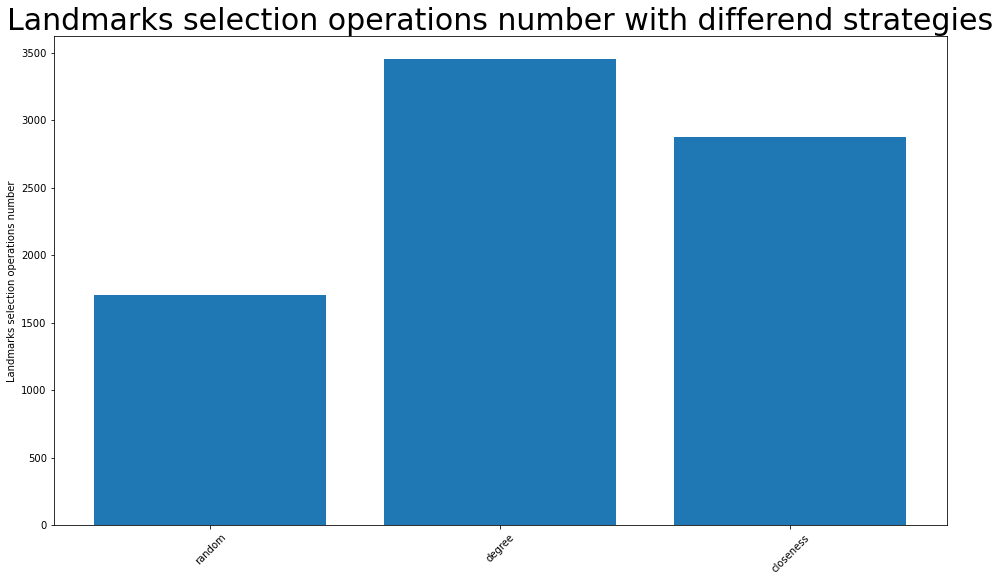

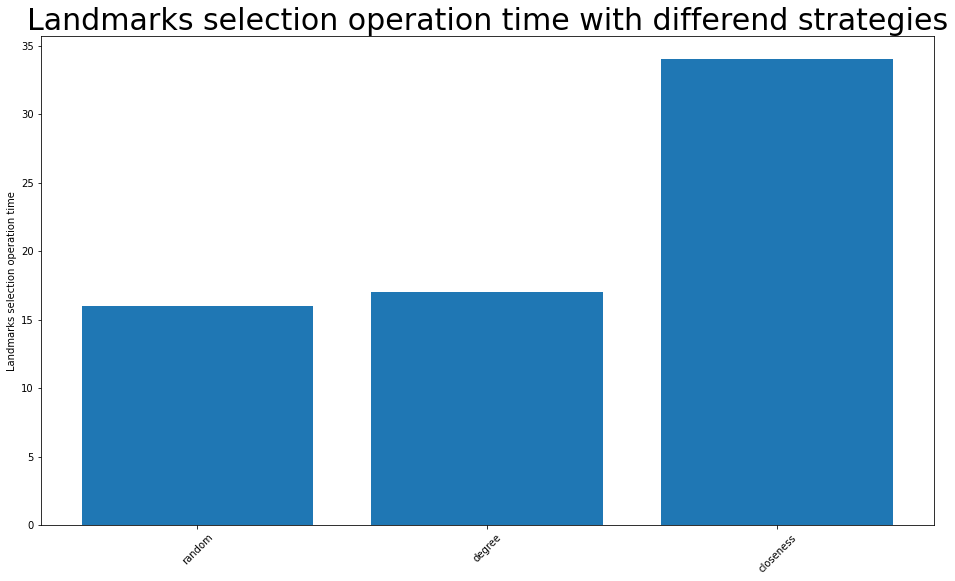

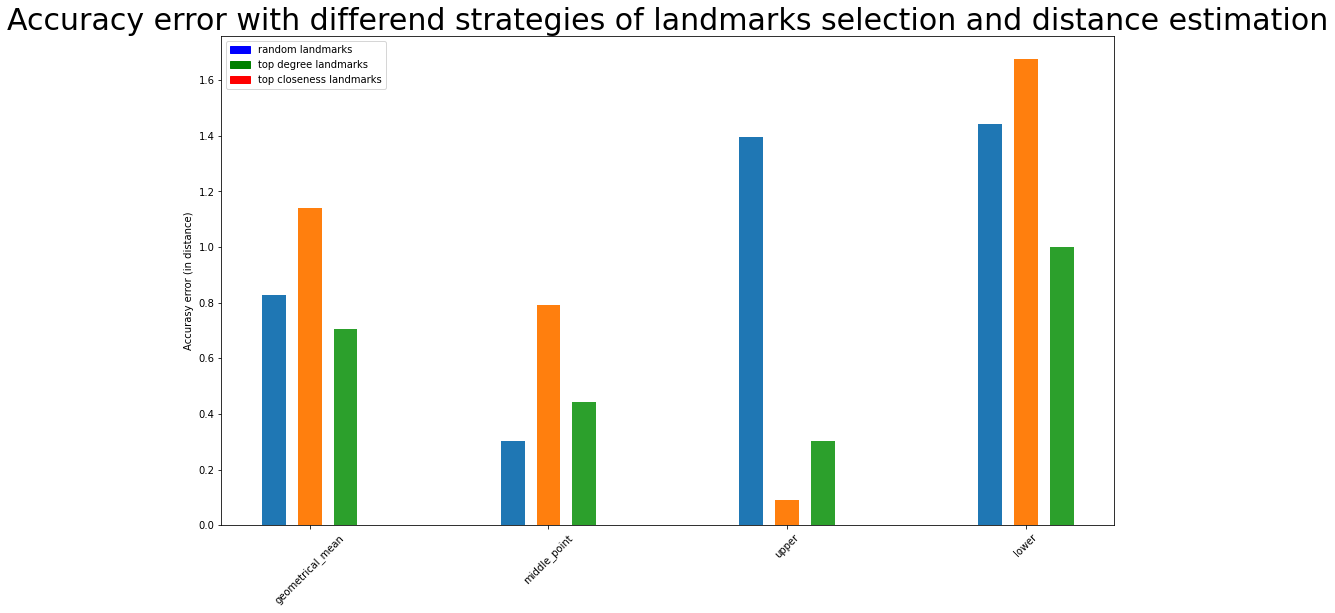

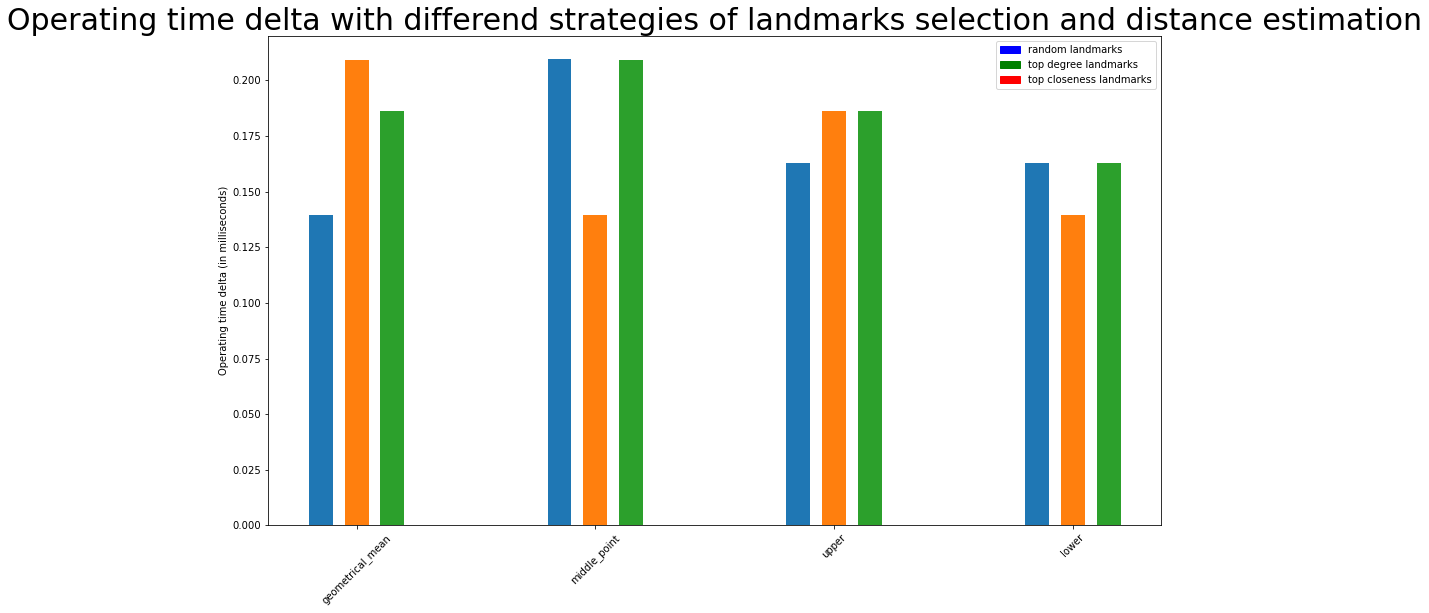

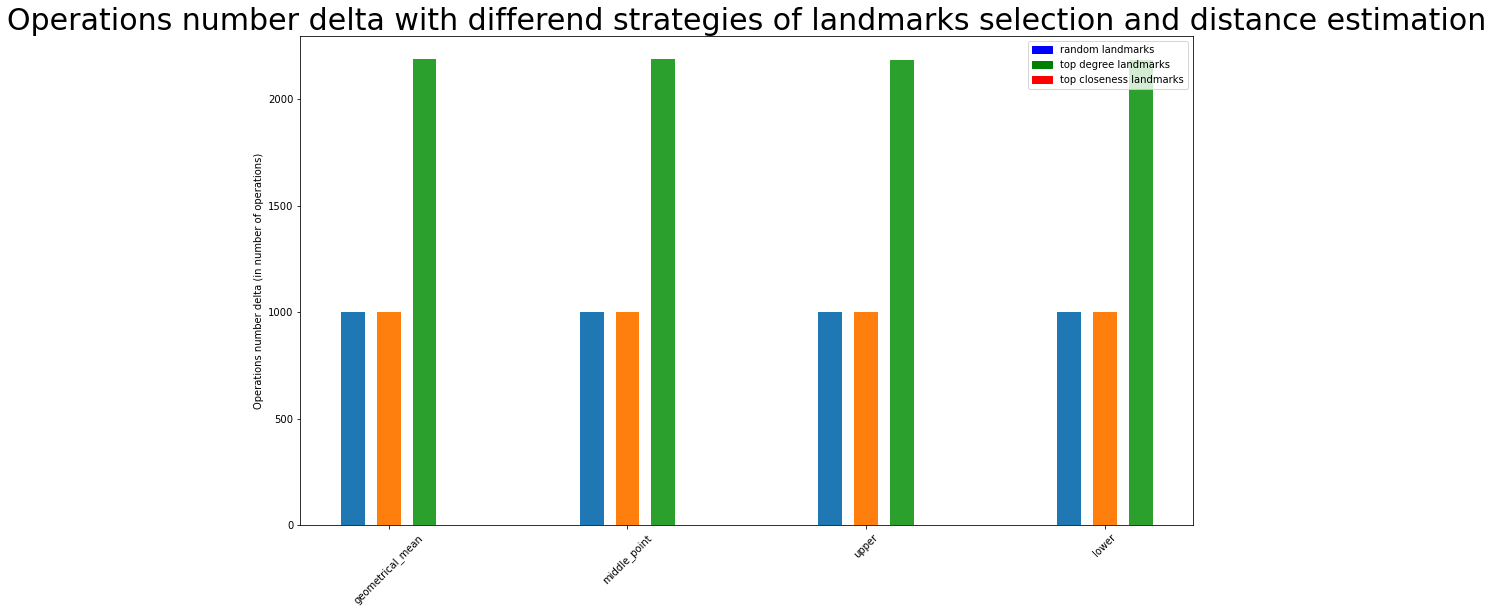

In [48]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['random', 'degree', 'closeness']

# Landmarks selection operations number

plt.figure(figsize=(16,9))

y = [
    results['random']['selection_operations'],
    results['degree']['selection_operations'],
    results['closeness']['selection_operations']
]

plt.bar(np.arange(len(labels)), y, align='center')

plt.xticks(range(len(labels)), labels, rotation=45)

plt.ylabel('Landmarks selection operations number')
plt.title('Landmarks selection operations number with differend strategies', fontsize=30)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'Landmarks_selection_operations.jpg', dpi=100, bbox_inches='tight')
plt.show()

# Landmarks selection operation time

plt.figure(figsize=(16,9))

y = [
    results['random']['selection_time'],
    results['degree']['selection_time'],
    results['closeness']['selection_time']
]

plt.bar(np.arange(len(labels)), y, align='center')

plt.xticks(range(len(labels)), labels, rotation=45)

plt.ylabel('Landmarks selection operation time')
plt.title('Landmarks selection operation time with differend strategies', fontsize=30)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'Landmarks_selection_time.jpg', dpi=100, bbox_inches='tight')
plt.show()



labels = plot_data['random']['beans']  # choose any landmark selecting strategy
colors = {'random landmarks': 'blue', 'top degree landmarks': 'green', 'less closeness landmarks': 'red'}


# Accuracy error

plt.figure(figsize=(16,9))

y1 = plot_data['random']['accuracy']
y2 = plot_data['degree']['accuracy']
y3 = plot_data['closeness']['accuracy']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.ylabel('Accurasy error (in distance)')
plt.title('Accuracy error with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'accuracy_error.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operating time delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['time_delta']
y2 = plot_data['degree']['time_delta']
y3 = plot_data['closeness']['time_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)

plt.ylabel('Operating time delta (in milliseconds)')
plt.title('Operating time delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operating_time_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()


# Operations number delta

plt.figure(figsize=(16,9))

y1 = plot_data['random']['operations_delta']
y2 = plot_data['degree']['operations_delta']
y3 = plot_data['closeness']['operations_delta']

plt.bar(np.arange(len(labels)) - 0.15, y1, align='center', width = 0.1)
plt.bar(np.arange(len(labels)), y2, align='center', width = 0.1)
plt.bar(np.arange(len(labels)) + 0.15, y3, align='center', width = 0.1)

plt.xticks(range(len(labels)), labels, rotation=45)
plt.ylabel('Operations number delta (in number of operations)')

plt.title('Operations number delta with differend strategies of landmarks selection and distance estimation', fontsize=30)
plt.legend(
    [plt.Rectangle((0, 0), 1, 1, color=colors[color[0]]) for color in colors.items()],
    list(colors.keys())
)

if SAVE_PLOTS:
    plt.savefig(SAVE_FOLDER + 'operations_number_delta.jpg', dpi=100, bbox_inches='tight')
plt.show()